In [12]:
import sys

import pandas as pd
import numpy as np
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

import sqlite3 as lite


In [13]:
def save_event(name, connection_path='/Users/b/Library/Containers/com.hesterlab.smartppe.facebit-app/Data/Documents/db.sqlite'): 
    conn = lite.connect(database_path)
    # conn = lite.connect('/Users/b/Downloads/db_mask_on.sqlite')
    events_query = f"""
        SELECT t.id, t.value, t.date, read.data_type as type, e.id as event_id, e.event_type, read.frequency 
        FROM time_series_measurement as t
        LEFT JOIN event as e ON e.id = t.event_id
        LEFT JOIN time_series_data_read as read ON t.data_read_id = read.id
        WHERE e.id == {18}
        ORDER BY t.date ASC
    """

    df = pd.read_sql_query(events_query, conn)
    df = df.where(df['type'] == 'pressure').dropna()
    df.to_csv(f'mask-wear-events/{name}.csv')

    return df

,id,event_type,other_event_label,notes,start_date,end_date
0,1,normal_breathing,,,2021-02-10T15:11:17.768Z,2021-02-10T15:16:31.971Z
1,2,mask_off,,,2021-02-10T16:24:58.080Z,2021-02-10T16:30:19.697Z
2,3,talking,,,2021-02-10T16:36:36.248Z,2021-02-10T16:42:36.468Z
3,7,normal_breathing,,,2021-02-10T18:12:13.342Z,2021-02-10T18:17:20.756Z
4,8,mask_off,,,2021-02-10T18:27:50.098Z,2021-02-10T18:32:57.538Z
5,9,talking,,,2021-02-10T18:34:38.790Z,2021-02-10T18:39:50.959Z
6,10,cough,,,2021-02-10T20:53:29.987Z,2021-02-10T20:53:36.417Z
7,11,cough,,,2021-02-10T20:57:58.068Z,2021-02-10T20:58:06.406Z
8,12,cough,,,2021-02-10T22:18:16.970Z,2021-02-10T22:18:24.618Z
9,13,cough,,,2021-02-10T22:18:40.260Z,2021-02-10T22:18:52.599Z


In [18]:
events = [pd.read_csv(f'mask-wear-events/{f}') for f in os.listdir('mask-wear-events')]

In [22]:
def plot_on_off(df):

    mean_freq = df['frequency'].mean()
    std_freq = df['frequency'].std()
    print(f'Mean of Frequency: {mean_freq:.4f}\nStandard Deviation frequency: {std_freq:.4f}')
    
    diffs = []
    stdevs = []
    signal = df['value'].to_numpy()

    window = int(mean_freq * 5)
    stride = int(mean_freq * 5)

    print(len(signal), window)

    for i in range(0, len(signal)-window, stride):
        sample = signal[i:i+window]
        diffs.append(max(sample) - min(sample))
        stdevs.append(np.std(sample))

    diffs = np.array(diffs)
    stdevs = np.array(stdevs)

    plt.plot(diffs)
    plt.plot(np.repeat([0.15], len(diffs))) 
    plt.show()
    
    plt.plot(stdevs)
    plt.plot(np.repeat([0.04], len(stdevs)))
    plt.show()

    is_on = diffs > 0.15

    state_changes = []
    for i, state in enumerate(is_on[:-1]):
        if is_on[i+1] != state:
            next_state_change_idx = np.argmax(is_on[i+1:]==state)
            print(next_state_change_idx)
            
            if next_state_change_idx >= 3 or next_state_change_idx==0: 
                state_changes.append(1)
                continue
        

        state_changes.append(0)

    is_on = np.repeat(is_on, len(signal)/len(is_on))
    state_changes = np.repeat(state_changes, len(signal)/len(state_changes))

    fig, ax1 = plt.subplots()
    ax1.plot(signal)

    ax2 = ax1.twinx()
    ax2.plot(is_on, c='red')
    ax2.plot(state_changes, c='black')

    plt.show()



Mean of Frequency: 25.4460
Standard Deviation frequency: 0.0187
5759 127


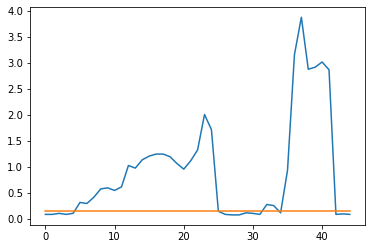

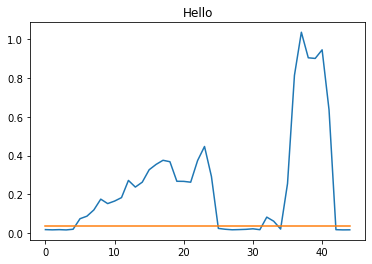

21
6
2
1
7
0


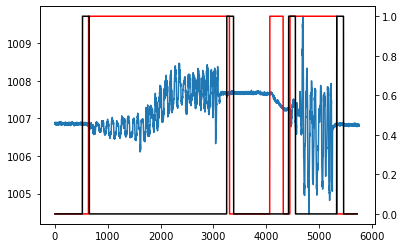

Mean of Frequency: 25.4585
Standard Deviation frequency: 0.0106
3600 127


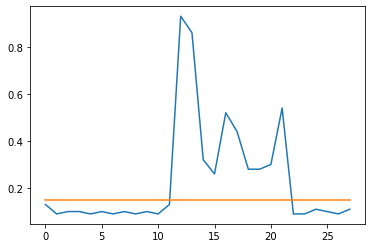

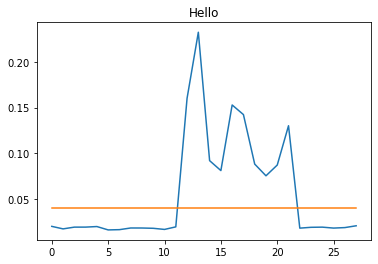

10
0


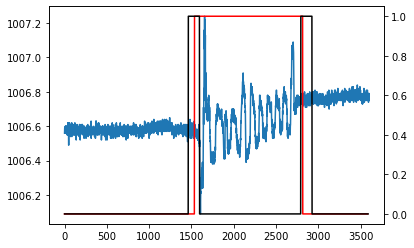

Mean of Frequency: 25.4666
Standard Deviation frequency: 0.0144
5631 127


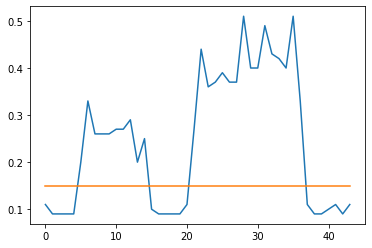

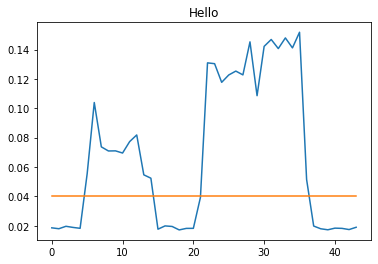

10
6
16
0


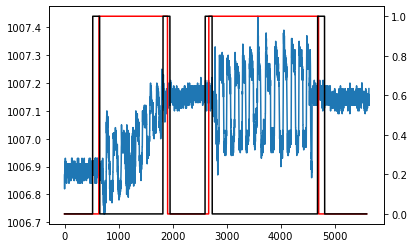

In [23]:
for event in events:
    plot_on_off(event)